In [1]:
import data_reader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

data_path = 'C:/Users/Arkady/Google Drive/data/beyond_the_reach'

# Extract k-values

In [2]:
dr = data_reader.DataReader()
choices, dynamics = dr.read_data(data_path)

In [110]:
choices = pd.read_csv(os.path.join(data_path, 'choices_processed.txt'), sep=',')
# choices = choices.set_index(['subj_id', 'task', 'trial_no'])

In [85]:
def get_indifference_point_staircase(choices, delay):
    if len(choices[~choices.ss_chosen])==0:
        ip = 0
    elif len(choices[choices.ss_chosen])==0:
         ip = 1
    else:
        ip = (choices[choices.ss_chosen].amount_ratio.min()
                + choices[~choices.ss_chosen].amount_ratio.max())/2
    return ip

def get_indifference_points(choices_sc):
    indiff_points = (choices_sc.groupby(['subj_id', 'task', 'll_delay'])
                     .apply(lambda c: get_indifference_point_staircase(c, c.iloc[0].ll_delay))
                     .rename('indiff_point'))
    return indiff_points

def get_k(indiff_points, log_delay=False):
    '''
    Many "raw" k-values are close to 1, and to emphasize the differences between those, we
    might (or might not?) want to log-scale the delays before calculating k-values
    '''
    delays = indiff_points.ll_delay.unique()
    if log_delay:
        delays = np.log(delays)
    delays = delays/max(delays)
#     print((delays[1:] - delays[:-1]))
    values = indiff_points.indiff_point.values
#     print((values[:-1] + values[1:]))
    
    k = 1 - ((delays[1:] - delays[:-1]) * (values[:-1] + values[1:]) / 2).sum()

    return k

In [115]:
def get_k_values(choices):
    ip = get_indifference_points(choices[choices.is_staircase]).reset_index()

    k_values = ip.groupby(['subj_id', 'task']).apply(lambda x: get_k(x, log_delay=False)).rename('k-value').unstack().reset_index()
#     k_values_log = ip.groupby(['subj_id', 'task']).apply(lambda x: get_k(x, log_delay=True)).rename('k-value')
    
    k_values['k_diff'] = k_values.mouse - k_values.walking
    k_values['k_mean'] = (k_values.mouse + k_values.walking)/2
   
    return k_values, ip

def save_k_values(k_values):
    k_values = pd.DataFrame([k_values.loc[:,['mouse', 'walking']].stack()]).T.reset_index()
    k_values = k_values.join(choices.groupby('subj_id').order.first())
    k_values.index.names = ['subj_id', 'task']
    k_values.columns = ['k', 'order']
    k_values.to_csv(os.path.join(data_path, 'k-values.txt'), sep='\t')

# Exclusion based on k-values

We exclude subjects who discounted too much or too little in *both* tasks

In [111]:
k_values, ip = get_k_values(choices)
extreme_k = k_values.loc[((k_values.mouse>0.98)&(k_values.walking>0.98)) | 
                         ((k_values.mouse<0.02)&(k_values.walking<0.02)), 'subj_id']
choices = choices[~choices.subj_id.isin(extreme_k)]

In [114]:
print(len(extreme_k))
print(extreme_k.values)

12
[1095 1122 1282 3846 4232 4679 5389 5571 7095 7958 8767 9790]


In [128]:
k_values

task,subj_id,mouse,walking,k_diff,k_mean
0,1402,0.974443,0.988199,-0.013756,0.981321
1,1408,0.404766,0.527640,-0.122874,0.466203
2,1474,0.879623,0.981864,-0.102240,0.930743
3,1578,0.989498,0.964826,0.024672,0.977162
4,1879,0.829281,0.888328,-0.059047,0.858804
5,2157,0.963513,0.884175,0.079338,0.923844
6,2249,0.964170,0.953467,0.010702,0.958818
7,2261,0.900086,0.844235,0.055850,0.872160
8,2311,0.894463,0.864141,0.030322,0.879302
9,2758,0.902811,0.781364,0.121447,0.842088


In [127]:
pd.melt(k_values, id_vars=['mouse'], value_vars=['B'])

TypeError: wide_to_long() missing 3 required positional arguments: 'stubnames', 'i', and 'j'

In [125]:
pd.DataFrame([k_values.loc[:,['mouse', 'walking']].stack()]).T

0
   task             
0  mouse    0.974443
   walking  0.988199
1  mouse    0.404766
   walking  0.527640
2  mouse    0.879623
   walking  0.981864
3  mouse    0.989498
   walking  0.964826
4  mouse    0.829281
   walking  0.888328
5  mouse    0.963513
   walking  0.884175
6  mouse    0.964170
   walking  0.953467
7  mouse    0.900086
   walking  0.844235
8  mouse    0.894463
   walking  0.864141
9  mouse    0.902811
   walking  0.781364
10 mouse    0.925856
   walking  0.817095
11 mouse    0.962500
   walking  0.922803
12 mouse    0.240611
   walking  0.485074
13 mouse    0.903567
   walking  0.878938
14 mouse    0.914498
   walking  0.888927
...              ...
36 mouse    0.422089
   walking  0.757306
37 mouse    0.666039
   walking  0.731364
38 mouse    0.931735
   walking  0.909475
39 mouse    0.737215
   walking  0.685160
40 mouse    0.977497
   walking  0.984261
41 mouse    0.954780
   walking  0.980123
42 mouse    0.931735
   walking  0.927697
43 mouse    0.561615
   walking  0.744863
44 mouse    0.657249
   walking  0.655237
45 mouse    0.927925
   walking  0.952811
46 mouse    0.567694
   walking  0.448773
47 mouse    0.508576
   walking  0.341182
48 mouse    0.817937
   walking  0.679709
49 mouse    0.712586
   walking  0.868151
50 mouse    0.901598
   walking  0.815696

[102 rows x 1 columns]

In [116]:
k_values, ip = get_k_values(choices)
save_k_values(k_values)

ValueError: cannot join with no level specified and no overlapping names

# Basic k-value analysis

0.011964477571850648


Ttest_1sampResult(statistic=0.6367885213434928, pvalue=0.5271674426412426)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


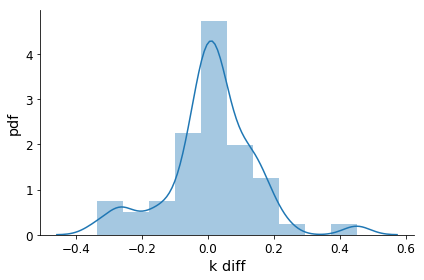

In [12]:
g = sns.distplot(k_values.k_diff, bins=10)
g.axes.set_xlabel('k diff')
g.axes.set_ylabel('pdf')
print(k_values.k_diff.mean())

from scipy.stats import ttest_1samp

ttest_1samp(k_values.k_diff, popmean=0)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


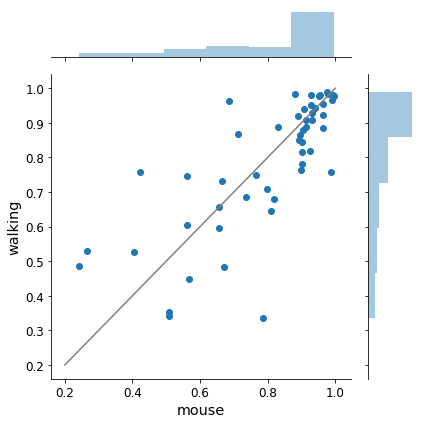

In [13]:
g = sns.jointplot(data=k_values, x='mouse', y='walking')
x = np.linspace(0.2, 1)
g.ax_joint.plot(x, x, color='grey')

In [125]:
k_long = (k_values.loc[:,['mouse', 'walking']]
          .stack().rename('k-value').reset_index()
          .set_index('subj_id').join(k_values.order)
          .rename({'level_1': 'task'}, axis='columns'))

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


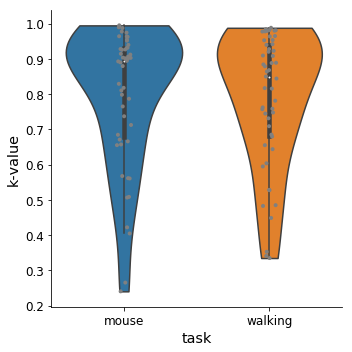

In [14]:
# sns.catplot(data=k_values.loc[:,['mouse', 'walking']].stack().rename('k-value').reset_index(), 
#             x='task', y='k-value', kind='violin')

ax = sns.catplot(data=k_values.loc[:,['mouse', 'walking']].stack().rename('k-value').reset_index().rename({'level_1': 'task'}, axis='columns'), 
                 x='task', y='k-value', 
                 kind='violin', cut=0)
ax = sns.stripplot(data=k_values.loc[:,['mouse', 'walking']].stack().rename('k-value').reset_index().rename({'level_1': 'task'}, axis='columns'),
                   x='task', y='k-value',
                   size=4, jitter=0.05, color="gray")

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


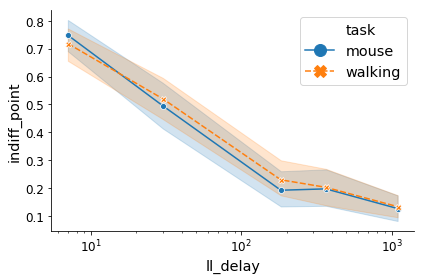

In [15]:
ax = sns.lineplot(data=ip.reset_index(), x='ll_delay', y='indiff_point', hue='task', style='task', markers=True)
sns.despine()
ax.set_xscale('log')

# Task effect might depending on individuals' k?

In [12]:
k_values_long = pd.melt(k_values, id_vars=['subj_id', 'k_quantile'], 
                        value_vars=['mouse', 'walking'], value_name='k-value')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


It seems that the effect of task might be individual-specific. E.g., people might not universally choose more SS in the walking task, but they might choose their default option more often in that task

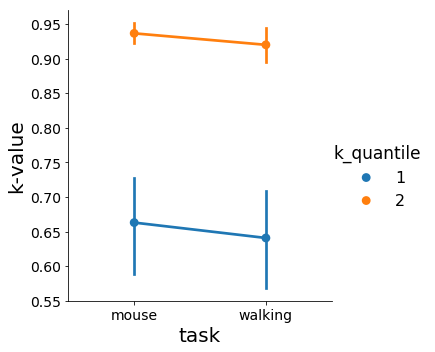

In [13]:
sns.catplot(data=k_values_long, x='task', y='k-value', hue='k_quantile', kind='point')

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


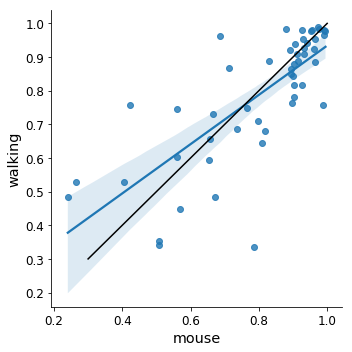

In [36]:
f = sns.lmplot(data=k_values, x='mouse', y='walking', truncate=True)
x = np.linspace(0.3, 1.0)
f.ax.plot(x, x, color='k')

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


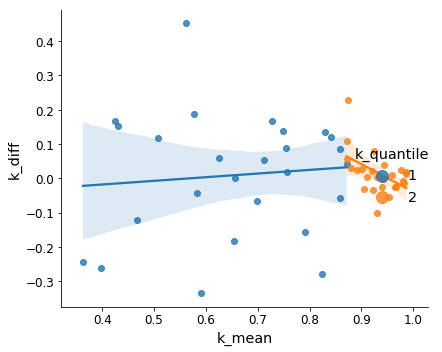

In [30]:
ax = sns.lmplot(data=k_values, x='k_mean', y='k_diff', hue='k_quantile', truncate=True)